## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, FastICA
from sklearn.feature_selection import SelectKBest, f_regression, f_classif, RFE, VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, SGDRegressor, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, silhouette_score
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from time import perf_counter
import numpy.linalg as LA
import os
os.environ["OMP_NUM_THREADS"] = "1"

## DataSet

In [2]:
df_class = pd.read_csv('data.csv')
df_reg = pd.read_csv('HousingData.csv')
df_cluster = pd.read_csv('Iris.csv')

## PreProcessing

In [3]:
def check_missing(df, name):
    print(f"Checking missing values in {name}:")
    print(df.isnull().sum()) 
    
    if df.isnull().values.any():
        print(f"Missing values found in {name}!")
        print("\nRows containing missing values:")
        print(df[df.isnull().any(axis=1)])
        
        df_drop = df.dropna()
        print(f" Number of rows after dropping missing values: {len(df_drop)}")

        df_fill = df.fillna(df.mean(numeric_only=True))
        print(f"Missing values replaced with column means.")
    else:
        print(f"No missing values found in {name}.")
        
check_missing(df_class, 'df_class')
check_missing(df_reg, 'df_reg')
check_missing(df_cluster, 'df_cluster')

Checking missing values in df_class:
id                           0
diagnosis                    0
radius_mean                  0
texture_mean                 0
perimeter_mean               0
area_mean                    0
smoothness_mean              0
compactness_mean             0
concavity_mean               0
concave points_mean          0
symmetry_mean                0
fractal_dimension_mean       0
radius_se                    0
texture_se                   0
perimeter_se                 0
area_se                      0
smoothness_se                0
compactness_se               0
concavity_se                 0
concave points_se            0
symmetry_se                  0
fractal_dimension_se         0
radius_worst                 0
texture_worst                0
perimeter_worst              0
area_worst                   0
smoothness_worst             0
compactness_worst            0
concavity_worst              0
concave points_worst         0
symmetry_worst               0
fr

## Features and Target

In [4]:
# Classification dataset (data.csv) 
df_class = df_class.drop(['id', 'Unnamed: 32'], axis=1)
X_class = df_class.drop('diagnosis', axis=1)
y_class = df_class['diagnosis'].map({'M': 1, 'B': 0})

# Regression dataset (HousingData.csv) 
df_reg = df_reg.dropna() 
X_reg = df_reg.drop('MEDV', axis=1)
y_reg = df_reg['MEDV']

# Clustering dataset (Iris.csv)
df_cluster = df_cluster.drop('Id', axis=1)
X_cluster = df_cluster.drop('Species', axis=1)
y_cluster = df_cluster['Species']

## Heat Map

data:


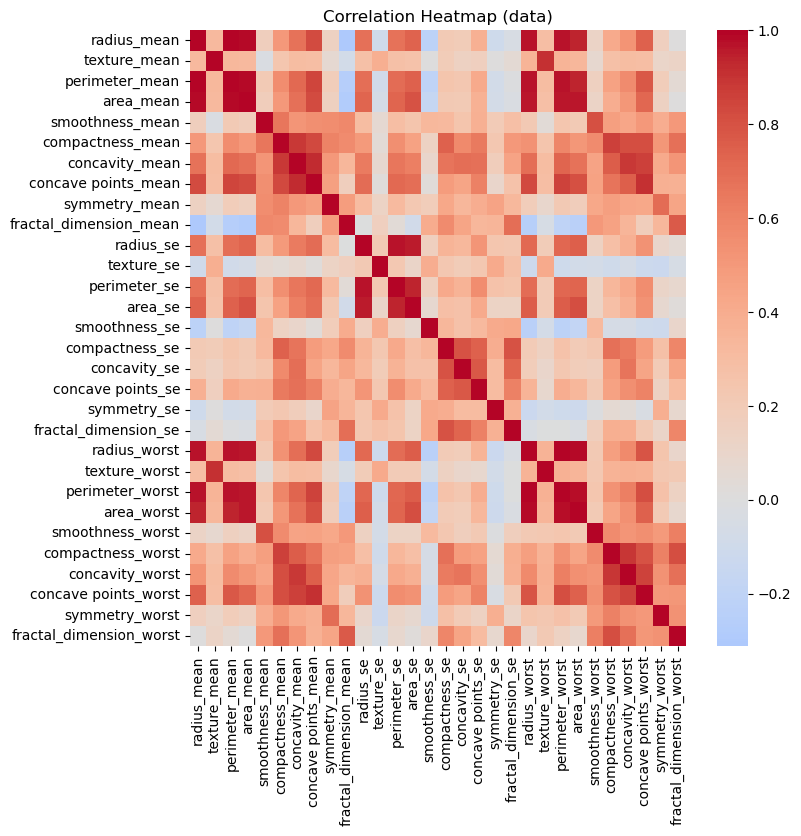

HousingData:


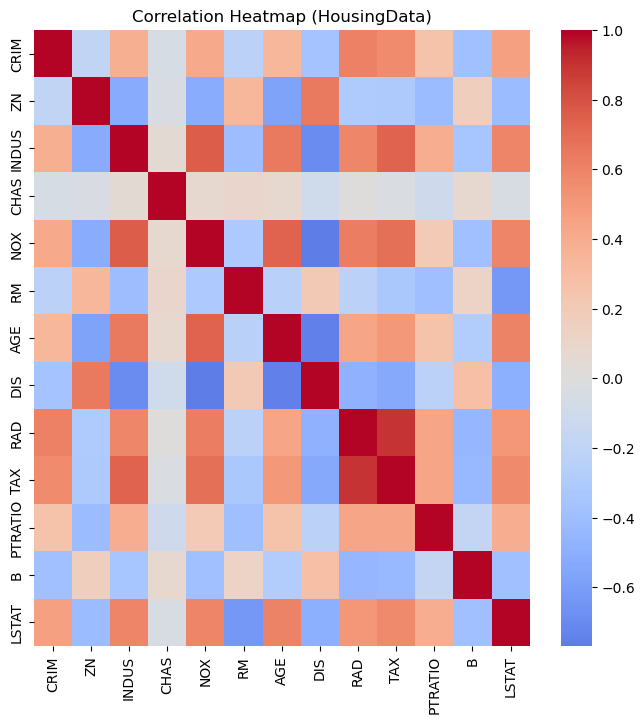

Iris:


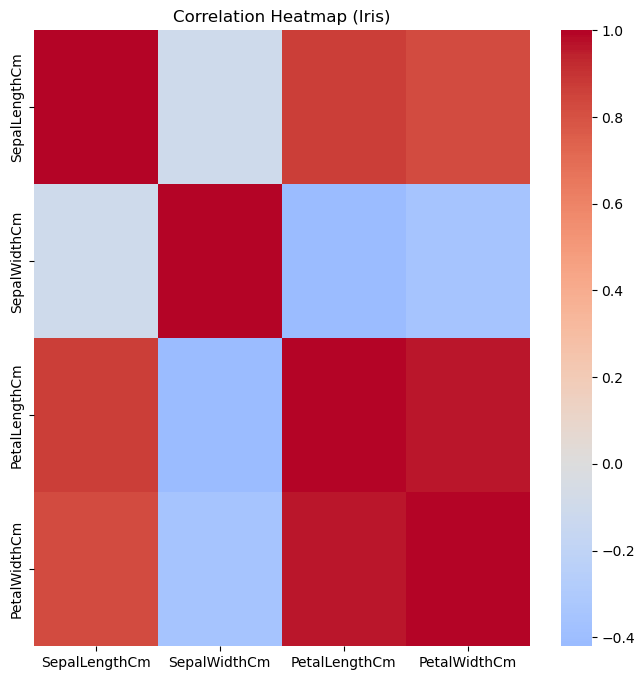

In [5]:
def plot_heatmap(matrix, title):
    plt.figure(figsize=(8, 8))
    sns.heatmap(matrix, cmap='coolwarm', center=0)
    plt.title(title)
    plt.savefig(f"{title}.pdf", format='pdf')
    plt.show()


# Classification
print("data:")
corr_class = X_class.corr()
plot_heatmap(corr_class, "Correlation Heatmap (data)")

# Regression 
print("HousingData:")
corr_reg = X_reg.corr()
plot_heatmap(corr_reg, "Correlation Heatmap (HousingData)")

# Clustering 
print("Iris:")
corr_cluster = X_cluster.corr()
plot_heatmap(corr_cluster, "Correlation Heatmap (Iris)")

## Feature Extraction

 Feature Extraction for Classification (Breast Cancer)


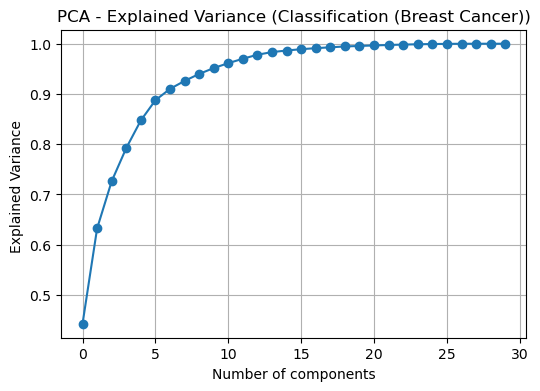

Number of PCA components for 95% variance: 10
ICA transformed shape: (569, 10)
SVD singular values shape: (30,)
 Feature Extraction for Regression (Housing)


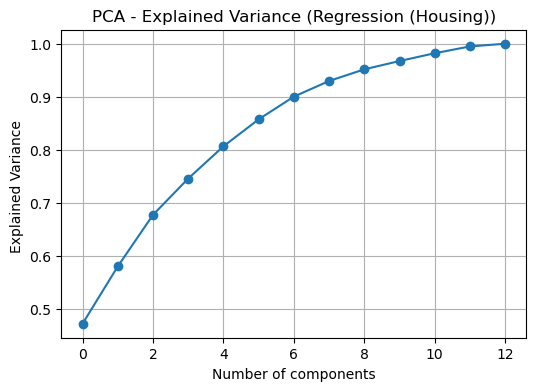

Number of PCA components for 95% variance: 9
ICA transformed shape: (394, 10)
SVD singular values shape: (13,)
 Feature Extraction for Clustering (Iris)


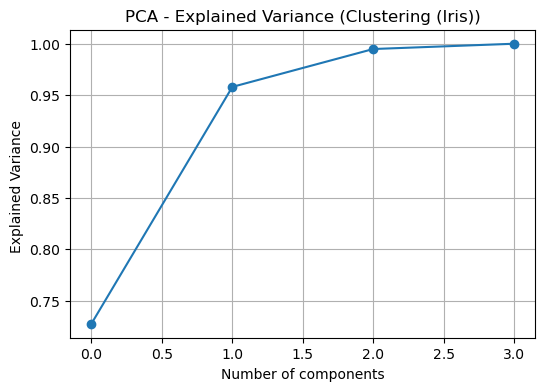

Number of PCA components for 95% variance: 2
ICA transformed shape: (150, 4)
SVD singular values shape: (4,)


In [6]:
def feature_extraction(X, dataset_name):
    print(f" Feature Extraction for {dataset_name}")

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # PCA 
    pca = PCA()
    pca.fit(X_scaled)
    explained = np.cumsum(pca.explained_variance_ratio_)

    plt.figure(figsize=(6,4))
    plt.plot(explained, marker='o')
    plt.title(f"PCA - Explained Variance ({dataset_name})")
    plt.xlabel('Number of components')
    plt.ylabel('Explained Variance ')
    plt.grid(True)
    plt.savefig(f"{dataset_name}.pdf", format='pdf')
    plt.show()

    n_components_95 = np.argmax(explained >= 0.95) + 1
    print(f"Number of PCA components for 95% variance: {n_components_95}")

    X_pca = PCA(n_components=n_components_95).fit_transform(X_scaled)

    # ICA 
    n_components_ica = min(10, X.shape[1]) 
    ica = FastICA(n_components=n_components_ica, random_state=0)
    X_ica = ica.fit_transform(X_scaled)
    print(f"ICA transformed shape: {X_ica.shape}")

    # SVD 
    U, s, VT = LA.svd(X_scaled, full_matrices=False)
    print(f"SVD singular values shape: {s.shape}")

    return X_scaled, X_pca, X_ica, s

X_class_scaled, X_class_pca, X_class_ica, s_class = feature_extraction(X_class, "Classification (Breast Cancer)")
X_reg_scaled, X_reg_pca, X_reg_ica, s_reg = feature_extraction(X_reg, "Regression (Housing)")
X_cluster_scaled, X_cluster_pca, X_cluster_ica, s_cluster = feature_extraction(X_cluster, "Clustering (Iris)")


In [7]:
def feature_selection(X, y, dataset_name, task_type="classification"):
    print(f" Feature Selection for {dataset_name}")

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # SelectKBest
    if task_type == "classification":
        selector = SelectKBest(score_func=f_classif, k=5)
    else:
        selector = SelectKBest(score_func=f_regression, k=5)

    X_kbest = selector.fit_transform(X_scaled, y)
    selected_features = X.columns[selector.get_support()]
    print("Top 5 features (SelectKBest):")
    print(list(selected_features))

    # RFE (Recursive Feature Elimination)
    if task_type == "classification":
        base_model = LogisticRegression(max_iter=1000)
    else:
        base_model = LinearRegression()

    rfe = RFE(base_model, n_features_to_select=5)
    rfe.fit(X_scaled, y)
    selected_rfe = X.columns[rfe.support_]
    print("Top 5 features (RFE):")
    print(list(selected_rfe))

    # VarianceThreshold
    vt = VarianceThreshold(threshold=0.01)
    X_vt = vt.fit_transform(X_scaled)
    print("Remaining features after VarianceThreshold:", X_vt.shape[1])

    return X_scaled, X_kbest, X_vt, selected_features, selected_rfe

X_class_scaled, X_class_kbest, X_class_vt, feats_class_kbest, feats_class_rfe = feature_selection(
    X_class, y_class, "Classification (Breast Cancer)", task_type="classification"
)

X_reg_scaled, X_reg_kbest, X_reg_vt, feats_reg_kbest, feats_reg_rfe = feature_selection(
    X_reg, y_reg, "Regression (Housing)", task_type="regression"
)

scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X_cluster)
vt = VarianceThreshold(threshold=0.01)
X_cluster_vt = vt.fit_transform(X_cluster_scaled)
print("Clustering (Iris) - VarianceThreshold:", X_cluster_vt.shape[1], "features remain")


 Feature Selection for Classification (Breast Cancer)
Top 5 features (SelectKBest):
['perimeter_mean', 'concave points_mean', 'radius_worst', 'perimeter_worst', 'concave points_worst']
Top 5 features (RFE):
['radius_se', 'radius_worst', 'texture_worst', 'area_worst', 'concave points_worst']
Remaining features after VarianceThreshold: 30
 Feature Selection for Regression (Housing)
Top 5 features (SelectKBest):
['INDUS', 'RM', 'TAX', 'PTRATIO', 'LSTAT']
Top 5 features (RFE):
['NOX', 'RM', 'DIS', 'PTRATIO', 'LSTAT']
Remaining features after VarianceThreshold: 13
Clustering (Iris) - VarianceThreshold: 4 features remain


## Classification

In [8]:
# Classification Models (Breast Cancer)

print(" Classification for Breast Cancer Data")

datasets_class = [
    ("Original", X_class_scaled, y_class),
    ("PCA", X_class_pca, y_class),
    ("SelectKBest", X_class_kbest, y_class)
]

for name, X, y in datasets_class:
    print(f" {name} Dataset ")
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

    # KNN 
    knn = KNeighborsClassifier(n_neighbors=5)
    t0 = perf_counter()
    knn.fit(x_train, y_train)
    accuracy_knn = knn.score(x_test, y_test)
    t_pred_knn = perf_counter() - t0
    print(f"KNN - Accuracy: {accuracy_knn:.4f}, Prediction time: {t_pred_knn:.4f} s")

    # Random Forest
    rf = RandomForestClassifier(n_estimators=100, random_state=0)
    t0 = perf_counter()
    rf.fit(x_train, y_train)
    accuracy_rf = rf.score(x_test, y_test)
    t_pred_rf = perf_counter() - t0
    print(f"RandomForest - Accuracy: {accuracy_rf:.4f}, Prediction time: {t_pred_rf:.4f} s")

 Classification for Breast Cancer Data
 Original Dataset 
KNN - Accuracy: 0.9591, Prediction time: 0.3041 s
RandomForest - Accuracy: 0.9591, Prediction time: 0.5845 s
 PCA Dataset 
KNN - Accuracy: 0.9649, Prediction time: 0.0398 s
RandomForest - Accuracy: 0.9181, Prediction time: 0.4941 s
 SelectKBest Dataset 
KNN - Accuracy: 0.9474, Prediction time: 0.0267 s
RandomForest - Accuracy: 0.9474, Prediction time: 0.3192 s


## Regression

 Regression for Housing Data

Original Dataset
LinearRegression - MSE: 23.8845, R2: 0.6873
  Coefficients: [-0.74193109  1.12064438  0.16625028  0.83798111 -2.26670462  3.36159235
 -0.80281437 -3.25152044  2.05627518 -2.0782372  -1.89188125  0.82926056
 -2.3549647 ]
  Intercept: 22.29998244288167
SGDRegressor - MSE: 24.6314, R2: 0.6776
  Coefficients: [-0.97590245  1.08883979  0.03284554  0.93137287 -2.7179449   3.34019915
 -0.7147927  -3.34800682  2.19577459 -2.18634379 -2.1332552   0.64457493
 -2.31124238]
  Intercept: [22.28233627]

PCA Dataset
LinearRegression - MSE: 25.5504, R2: 0.6655
  Coefficients: [-2.39787261  2.03089562  3.35093637 -0.64091377  1.98434732  0.62351927
  0.55917651 -0.40410773  0.12958848]
  Intercept: 22.25852431672385
SGDRegressor - MSE: 25.8611, R2: 0.6615
  Coefficients: [-2.63686177  2.11473104  3.41446105 -0.6973344   1.83692296  0.34401526
  0.35253763 -0.3257976  -0.16616897]
  Intercept: [22.25353395]

SelectKBest Dataset
LinearRegression - MSE: 27.63

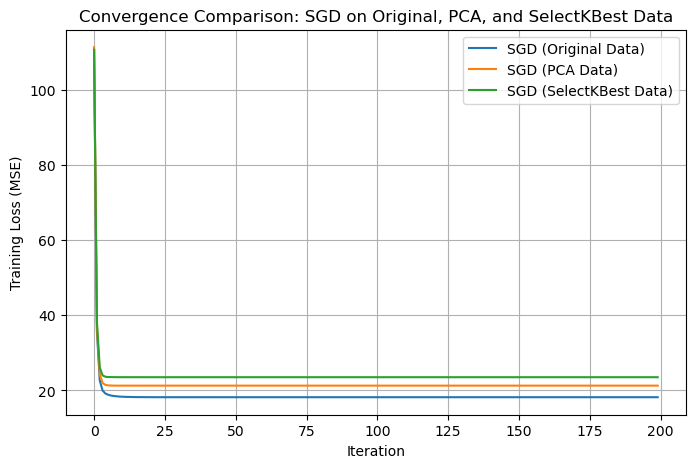

In [9]:
# Regression Models (HousingData)
print(" Regression for Housing Data")
datasets_reg = [
    ("Original", X_reg_scaled, y_reg),
    ("PCA", X_reg_pca, y_reg),
    ("SelectKBest", X_reg_kbest, y_reg)
]

def train_sgd_with_curve(X_train, y_train, max_iter=200):
    sgd = SGDRegressor(max_iter=1, learning_rate='invscaling', eta0=0.01,
                       warm_start=True, tol=None, random_state=0)
    losses = []
    for i in range(max_iter):
        sgd.fit(X_train, y_train)
        y_pred = sgd.predict(X_train)
        # (MSE)
        loss = np.mean((y_train - y_pred) ** 2)
        losses.append(loss)
    return sgd, losses

results = {}
for name, X, y in datasets_reg:
    print(f"\n{name} Dataset")

    # Split data into train/test
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

    # Linear Regression
    lr = LinearRegression()
    lr.fit(x_train, y_train)
    y_pred = lr.predict(x_test)
    print(f"LinearRegression - MSE: {mean_squared_error(y_test, y_pred):.4f}, "
          f"R2: {r2_score(y_test, y_pred):.4f}")
    print("  Coefficients:", lr.coef_)
    print("  Intercept:", lr.intercept_)

    # SGD Regressor
    sgd, losses = train_sgd_with_curve(x_train, y_train)
    y_pred_sgd = sgd.predict(x_test)
    print(f"SGDRegressor - MSE: {mean_squared_error(y_test, y_pred_sgd):.4f}, "
          f"R2: {r2_score(y_test, y_pred_sgd):.4f}")
    print("  Coefficients:", sgd.coef_)
    print("  Intercept:", sgd.intercept_)

    results[name] = losses
plt.figure(figsize=(8,5))
for name, losses in results.items():
    plt.plot(losses, label=f'SGD ({name} Data)')

plt.xlabel('Iteration')
plt.ylabel('Training Loss (MSE)')
plt.title('Convergence Comparison: SGD on Original, PCA, and SelectKBest Data')
plt.legend()
plt.grid(True)
plt.savefig("converge.pdf", format = 'pdf')
plt.show()

## Clustering

In [10]:
# Clustering Models (Iris)

print("Clustering for Iris Data")

datasets_cluster = [
    ("Original", X_cluster_scaled),
    ("PCA", X_cluster_pca),
    ("Reduced (VarianceThreshold)", X_cluster_vt)
]

for name, X in datasets_cluster:
    print(f" {name} Dataset")
    kmeans = KMeans(n_clusters=3, random_state=0)
    t0 = perf_counter()
    kmeans.fit(X)
    t1 = perf_counter()
    inertia = kmeans.inertia_
    sil = silhouette_score(X, kmeans.labels_)
    print(f"Inertia: {inertia:.2f}, Silhouette: {sil:.4f}, Time: {t1 - t0:.4f} s")

Clustering for Iris Data
 Original Dataset
Inertia: 141.22, Silhouette: 0.4557, Time: 0.0257 s
 PCA Dataset
Inertia: 116.11, Silhouette: 0.5082, Time: 0.0111 s
 Reduced (VarianceThreshold) Dataset
Inertia: 141.22, Silhouette: 0.4557, Time: 0.0116 s


c:\Users\PC\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\PC\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\PC\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


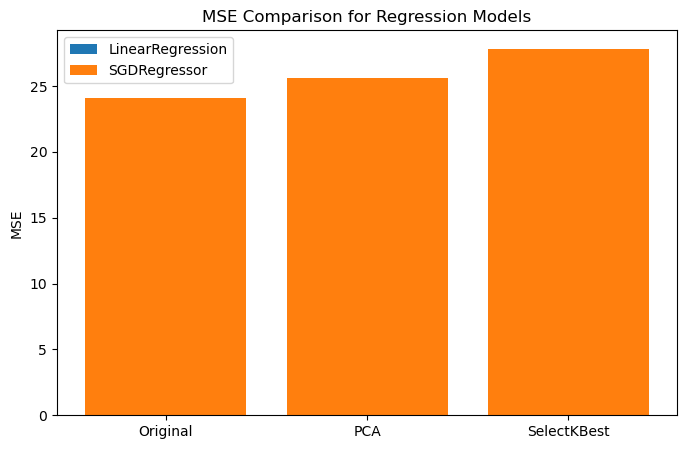

In [11]:

# Store regression results
results_reg = {
    'Dataset': [],
    'Model': [],
    'MSE': [],
    'R2': []
}

for name, X, y in datasets_reg:
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.3, random_state=0)

    # Linear Regression
    lr = LinearRegression()
    lr.fit(Xtr, ytr)
    y_pred = lr.predict(Xte)
    results_reg['Dataset'].append(name)
    results_reg['Model'].append('LinearRegression')
    results_reg['MSE'].append(mean_squared_error(yte, y_pred))
    results_reg['R2'].append(r2_score(yte, y_pred))

    # SGD Regressor
    sgd = SGDRegressor(max_iter=1000, tol=1e-3, random_state=0)
    sgd.fit(Xtr, ytr)
    y_pred_sgd = sgd.predict(Xte)
    results_reg['Dataset'].append(name)
    results_reg['Model'].append('SGDRegressor')
    results_reg['MSE'].append(mean_squared_error(yte, y_pred_sgd))
    results_reg['R2'].append(r2_score(yte, y_pred_sgd))

# Convert results to DataFrame
df_results_reg = pd.DataFrame(results_reg)

# Plot MSE Comparison
plt.figure(figsize=(8, 5))
for model in df_results_reg['Model'].unique():
    subset = df_results_reg[df_results_reg['Model'] == model]
    plt.bar(subset['Dataset'], subset['MSE'], label=model)
plt.title('MSE Comparison for Regression Models')
plt.ylabel('MSE')
plt.legend()
plt.savefig("RegCompare.pdf", format = 'pdf')
plt.show()


c:\Users\PC\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\PC\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\PC\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


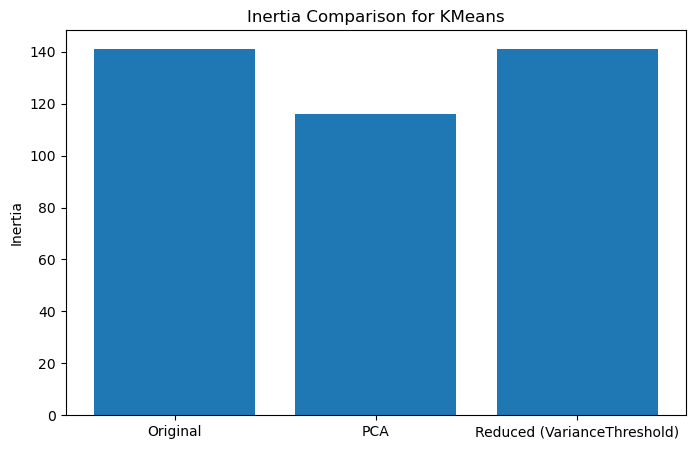

In [12]:
# Store clustering results
results_cluster = {
    'Dataset': [],
    'Inertia': [],
    'Silhouette': [],
    'Time (s)': []
}

for name, X in datasets_cluster:
    kmeans = KMeans(n_clusters=3, random_state=0)
    t0 = perf_counter()
    kmeans.fit(X)
    t1 = perf_counter()
    
    results_cluster['Dataset'].append(name)
    results_cluster['Inertia'].append(kmeans.inertia_)
    results_cluster['Silhouette'].append(silhouette_score(X, kmeans.labels_))
    results_cluster['Time (s)'].append(t1 - t0)

df_results_cluster = pd.DataFrame(results_cluster)

# Plot Inertia Comparison
plt.figure(figsize=(8, 5))
plt.bar(df_results_cluster['Dataset'], df_results_cluster['Inertia'])
plt.title('Inertia Comparison for KMeans')
plt.ylabel('Inertia')
plt.savefig("clusterCompare.pdf", format = 'pdf')
plt.show()

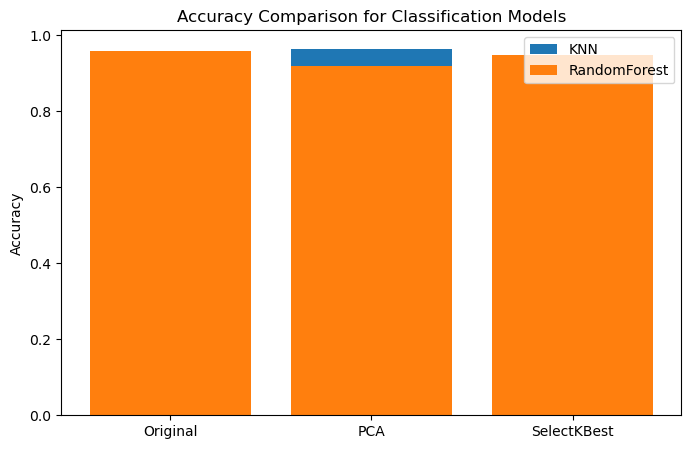

In [13]:
results_class = {
    'Dataset': [],
    'Model': [],
    'Accuracy': [],
    'Prediction Time (s)': []
}

for name, X, y in datasets_class:
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.3, random_state=0)

    # KNN
    knn = KNeighborsClassifier(n_neighbors=5)
    t0 = perf_counter()
    knn.fit(Xtr, ytr)
    acc_knn = knn.score(Xte, yte)
    t_pred_knn = perf_counter() - t0
    results_class['Dataset'].append(name)
    results_class['Model'].append('KNN')
    results_class['Accuracy'].append(acc_knn)
    results_class['Prediction Time (s)'].append(t_pred_knn)

    # Random Forest
    rf = RandomForestClassifier(n_estimators=100, random_state=0)
    t0 = perf_counter()
    rf.fit(Xtr, ytr)
    acc_rf = rf.score(Xte, yte)
    t_pred_rf = perf_counter() - t0
    results_class['Dataset'].append(name)
    results_class['Model'].append('RandomForest')
    results_class['Accuracy'].append(acc_rf)
    results_class['Prediction Time (s)'].append(t_pred_rf)

df_results_class = pd.DataFrame(results_class)

# Plot Accuracy
plt.figure(figsize=(8, 5))
for model in df_results_class['Model'].unique():
    subset = df_results_class[df_results_class['Model'] == model]
    plt.bar(subset['Dataset'], subset['Accuracy'], label=model)
plt.title('Accuracy Comparison for Classification Models')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig("classCompare.pdf", format = 'pdf')
plt.show()
